<a href="https://colab.research.google.com/github/salilathalye/chats-with-austin/blob/main/CWA_Try_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>Conversations with Austin</H1>
<h2>Try PyCaret - Classification
<p>I've been waiting for a while to take PyCaret out for a spin and proverbially kick the tires. I feel that we all need to experience building out a simple machine learning pipeline first before we can truly appreciate what PyCaret brings to the table. So that's what I did - I started out with an imbalanced dataset with some missing values with the aim of building a binary classifier. Did the preliminary EDA, made decisions on how to structure the data, picked out the features and 'manually' (i.e. no pipeline!) ran it through a restricted set of classifiers. Picked out a few model diagnostics to give me a decent sense of what was going on and then ran it through SHAP. Spat out the pickle file containing the transformers and the model, etc. Lot's of pulling from prior notebooks, getting all the cells lined up. Didn't do anything fancy in terms of using TPOT or auto-sklearn to build a pipeline. Nothing in the form of ensembles/stacking etc. You all have been through a similar wringer when asked to 'produce' a model, no?

Whew! That's a lot of work just to flesh out basic pipeline, but we ain't done yet. If it isn't in Production, it didn't happen, right?

Now try taking that model and building a Flask or Streamlit front-end. **You have to take the incoming request and go through the data to transmogrify it into the input that the model expects, so more code to copy over!** And when you change something (hey - try this new shiny trick etc.) in the model building phase you have to replicate it again in the application. Painful.

This is where PyCaret really shines. It builds out the pipeline and encapsulates it along with the model in your pickle file. Your app now just needs to conform the request to the dataframe the model expects. The time you save copying code from notebooks and the mental energy it requires to keep track of all your changes can be invested in ensuring that the **outputs meets the business need, ensuring that it brings value and will have a positive ROI**. At the end of the day that's what should put a smile on our faces!

There certainly is a lot to unpack in PyCaret and I'm not an expert - so I'm investing in some saw-sharpening: examining areas where I have some knowledge gaps and iteratively filling out the cracks, building out a template that I can reuse. Putting the many pieces together so I can both pay attention to what PyCaret is doing (trust, but verify) behind the scenes as well as expediently gathering the insight I need to ensure that the outputs meet the business need and arming myself with the decisions I need to take in the next iteration. 'Cause yeah, there will be many more spins in the cycle, that much we know.

Wait ... who is Austin, you ask? Austin the Apex Duck is my [Rubber Duck Debug buddy](https:en.wikipedia.org/wiki/Rubber_duck_debugging). Usually a pretty quiet type of guy, but I sense hidden depths of knowledge. Our chats usually start with me staring at something for a long time, then asking a question something like: "Hey Austin, what do you know about Kappa?". His usual response is: "Kappa? Tell me more, please". This usually starts a back and forth dialogue where he eggs (no pun intended!) me on to explain more. He's all about putting things in writing, which is why I'm sitting here taking notes which I'm cataloguing in a series called "Chats with Austin".

Salil Athalye
www.bokehboy.com


Data provided by [DPhi Tech](https://dphi.tech//) Assignment 3: Advanced: Loan or No Loan?
https://dphi.tech/practice/challenge/54


# Configure Environment and Install Packages
### Notes for Austin
* I'm specifically calling out pycaret 2.2.3 because they mentioned a fix with catboost. catboost turns out to be the best model, but I'm picking gbc to ensure I can generate predictions locally and then deploy the model to Heroku or AWS.

### Do your Research!
* I guess I could create a requirements.txt file in the repo and git clone it here. Then run pip install -r requirements.txt to setup the environment exactly the way we need it.

In [1]:
!pip install pycaret==2.2.3 --quiet
!pip install mlflow --quiet
!pip install shap --quiet

     |████████████████████████████████| 256kB 5.9MB/s 
     |████████████████████████████████| 14.2MB 308kB/s 
     |████████████████████████████████| 1.6MB 54.3MB/s 
     |████████████████████████████████| 1.8MB 41.1MB/s 
     |████████████████████████████████| 157.5MB 76kB/s 
     |████████████████████████████████| 276kB 44.9MB/s 
     |████████████████████████████████| 65.8MB 60kB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
     |████████████████████████████████| 266kB 41.4MB/s 
     |████████████████████████████████| 174kB 52.9MB/s 
     |████████████████████████████████| 6.8MB 41.4MB/s 
     |████████████████████████████████| 1.1MB 41.4MB/s 
     |████████████████████████████████| 163kB 48.2MB/s 
     |████████████████████████████████| 153kB 44.5MB/s 
     |████████████████████████████████| 337kB 48.9MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 2.1MB 39.0MB/s

# Import Libraries
### Notes to Austin
* It is important to keep track of the exact versions of PyCaret and Pandas. This is because when we deploy the model we need to recreate the environment that we used when we built the model. APIs change over time and future versions make be incompatible with prior versions. This is essential for reproducible machine learning pipelines.
* I ran into this problem where my local laptop was using an older version of Pandas and I was getting errors when trying to get a prediction from a loaded model. Syncing CoLab and my laptop with the exact same versions resolved the problem.
* There are at least 3 distinct environments we have to keep exactly in sync:
  - The Google Colab environment
  - My local laptop/desktop where I load the model and build the application
  - My cloud deployment environment such as Heroku, AWS, Azure where my application will serve predictions from the model.
* If you have multiple local machines, or you are working with a team you want to make sure that everyone has the same environment for each DTAP phase. We typically do this using a YAML file such as environment.yml for Conda and put this under version control. This way we can control the environment. Not sure how to do this in Colab as yet.
### Do your Research!
* TODO: I think I want to be prescriptive about the versions. Perhaps create variables for version numbers and then use them in the bash shell commands. Or is there a way to instantiate the Colab environment from a YAML file?

In [2]:
from datetime import datetime
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import json
from google.colab import files


# PyCaret
import pycaret
from pycaret.classification import * 
from pycaret.utils import enable_colab
enable_colab()


# MLflow
import mlflow
#TODO: How to set up an MLflow server which we can use with Colab? 
#mlflow.set_tracking_uri('file:/c:/users/mlflow-server')

import shap
#TODO: Not sure how PyCaret sets up shap.initjs() which is required for CoLab.

Colab mode enabled.


# Experiment Parameters
### Notes to Austin
* Remember how Azure Machine Learning stores the models build for each run? Need something similar. I liked how I could look at all the experiments and then precisely find the model and artifacts associated with that run of the experiment weeks or months later.
### Do your research!
* I feel like I want to append the chosen model to the experiment name. If its a bagged\blended\stacked model I will need some alternative nomenclature. I don't want zip files to collide with each other or us forgetting which model was used. Wonder if MLflow keeps track of models.
* TODO: See how we are setting constants for the CSV file names and then NOT using these in the github path? Need to perhaps make the base path a constant and then concatenate?

In [3]:
EXPERIMENT_NAME = 'dphi_ch54_1'
SESSION_ID = 3435
DATA_SOURCE = "https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data"
TRAINING_DATA = "loan_train.csv"
TEST_DATA = "loan_test.csv"
TARGET_COL = 'Loan_Status'
# Set this to False when converting this notebook to a Productions script
VERBOSE = True
# Optimize Threshold Costs (only for binary classifiers)
TP_COST = 0
TN_COST = 0
FP_COST = 0
FN_COST = 0
# Hyper-parameter search for model tuning
N_ITER = 10
# Should we download the run artifacts?
DOWNLOAD_ZIPFILE = True

In [4]:
MODEL = 'TBD' # we will populate this with the best model

dt = datetime.now()
dt.replace(tzinfo=timezone.utc)
utc_timestamp = dt.replace(tzinfo=timezone.utc).isoformat(timespec='seconds')
# Replace ':' and '-' and retain up to seconds
UTC_TIMESTAMP = utc_timestamp.replace(':','').replace('-',"")[:15]

TRAINING_DATA_PATH = DATA_SOURCE + '/' + TRAINING_DATA
TEST_DATA_PATH = DATA_SOURCE + '/' + TEST_DATA

# Load the data


In [5]:
# Dataset is provided by DPhi Tech
# raw.githubusercontent.com allows us to download 'raw' content of files stored on github
# NOTE: the training data was most likely saved out without setting index=False, so we need to get rid of the index column on read.
# This is only an issue for the training data file, test data file is fine.
# Credit_History comes in as a float, due to missing values and how pandas manages na_type_promotions
# Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#na-type-promotions
dtype_mapping = {}
training_data  = pd.read_csv(TRAINING_DATA_PATH, dtype=dtype_mapping, index_col=[0])
test_data = pd.read_csv(TEST_DATA_PATH, dtype=dtype_mapping)

# Save the raw data in case the source is unavailable later
training_data.to_csv(TRAINING_DATA, index=False)
test_data.to_csv(TEST_DATA, index=False)
# Save any decisions we took on dtype mapping so we can reuse this in other applications
with open('dtype_mapping.json','w') as f:
  json.dump(dtype_mapping, f)

###Data Description
* Loan_ID: A unique ID assigned to every loan applicant
* Gender: Gender of the applicant (Male, Female)
* Married: The marital status of the applicant (Yes, No)
* Dependents: No. of people dependent on the applicant (0,1,2,3+)
* Education: Education level of the applicant (Graduated, Not Graduated)
* Self_Employed: If the applicant is self-employed or not (Yes, No)
* ApplicantIncome: The amount of income the applicant earns
* CoapplicantIncome: The amount of income the co-applicant earns
* LoanAmount: The amount of loan the applicant has requested for
* Loan_Amount_Term: The  no. of days over which the loan will be paid
* Credit_History: A record of a borrower's responsible repayment of debts (1- has all debts paid, 0- not paid)
* Property_Area : The type of location where the applicant’s property lies (Rural, Semiurban, Urban)
* Loan_Status: Loan granted or not (Y, N)




In [6]:
test_data.shape

(123, 12)

In [7]:
training_data.shape

(491, 13)

In [8]:
test_data_columns = test_data.columns
training_data_columns = training_data.columns
#Set difference : columns in training_data that are not in test_data
columns_missing_in_test = set(training_data_columns) - set(test_data_columns)
print(columns_missing_in_test)

{'Loan_Status'}


In [9]:
training_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [10]:
training_data.head(5)

Loan_ID  Gender Married Dependents     Education Self_Employed  \
0  LP002305  Female      No          0      Graduate            No   
1  LP001715    Male     Yes         3+  Not Graduate           Yes   
2  LP002086  Female     Yes          0      Graduate            No   
3  LP001136    Male     Yes          0  Not Graduate           Yes   
4  LP002529    Male     Yes          2      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4547                0.0       115.0             360.0   
1             5703                0.0       130.0             360.0   
2             4333             2451.0       110.0             360.0   
3             4695                0.0        96.0               NaN   
4             6700             1750.0       230.0             300.0   

   Credit_History Property_Area  Loan_Status  
0             1.0     Semiurban            1  
1             1.0         Rural            1  
2             1.0         Urban            0  
3             1.0         Urban            1  
4             1.0     Semiurban            1

In [11]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 0 to 490
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             481 non-null    object 
 2   Married            490 non-null    object 
 3   Dependents         482 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      462 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         475 non-null    float64
 9   Loan_Amount_Term   478 non-null    float64
 10  Credit_History     448 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 53.7+ KB


In [12]:
training_data.isna().sum()

Loan_ID               0
Gender               10
Married               1
Dependents            9
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           16
Loan_Amount_Term     13
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
training_data.describe()

ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       491.000000         491.000000  475.000000        478.000000   
mean       5401.189409        1589.730998  145.014737        341.297071   
std        6419.427177        2919.320624   86.310534         66.964051   
min         150.000000           0.000000   17.000000         12.000000   
25%        2923.500000           0.000000  100.000000        360.000000   
50%        3865.000000        1229.000000  126.000000        360.000000   
75%        5705.500000        2251.500000  162.000000        360.000000   
max       81000.000000       41667.000000  700.000000        480.000000   

       Credit_History  Loan_Status  
count      448.000000   491.000000  
mean         0.848214     0.698574  
std          0.359214     0.459345  
min          0.000000     0.000000  
25%          1.000000     0.000000  
50%          1.000000     1.000000  
75%          1.000000     1.000000  
max          1.000000     1.000000

In [14]:
training_data[TARGET_COL].value_counts()

1    343
0    148
Name: Loan_Status, dtype: int64

# Perform Basic Exploratory Data Analysis
### Notes for Austin
* My EDA insights are in a different notebook, based only on the training data. What is the best way to fold this in? Want to be able to show the chain of reasoning, decisions taken etc.

#PyCaret - The magic and majesty starts HERE!


## Set up the Experiment
### Notes for Austin
* Only set silent=True when you are sure that PyCaret has interpreted the type of each feature correctly. Also remember that if use the default (silent=False), **PyCaret will pause here**, waiting for user confirmation!!!
* When you migrate to Production in the form of a Python script then set html=False.
* From EDA I know that the dataset is imbalanced and that there are missing values, hence I call for iterative imputation, using lightgbm, and I set fix_imbalance = True. When fix_imbalance_method = None, PyCaret will select SMOTE.
* Since I have logistic regression in play, I'm going to normalize the data.
* From EDA I also know that Loan_ID is a key, so I'm telling PyCaret to ignore this feature.
* Users of PyCaret will need to spend time to understand the options available and frame the experiment appropriately.
* log_experiment will set up the structure for MLflow outputs to local files. In Colab these show up in the content folder. Nice!
<p>

### Do your research!
* Criteria for setting PCA, Feature Selection, Outlier Handling
* There are about 60 parameters in setup(). We need to work our way through these!
* How to set up MLflow using Colab so I can see the runs in my local browser. Also get a server set up in AWS so we can track experiments.

In [15]:
experiment = setup(training_data, 
                    target = TARGET_COL, 
                    session_id=SESSION_ID, 
                    ignore_features=['Loan_ID'], # Loan_ID is a key
                    imputation_type="iterative", 
                    categorical_iterative_imputer="lightgbm", 
                    numeric_iterative_imputer="lightgbm", 
                    iterative_imputation_iters = 5,
                    normalize = True,
                    fix_imbalance = True,
                    fix_imbalance_method = None, # will use SMOTE when set to None
                    log_experiment = True,       # sets up MLflow using local files
                    experiment_name = EXPERIMENT_NAME,
                    silent=True,                 # set to True only when you confirm feature types selected by PyCaret
                    #html=False                  # set to False when converting this to a Production script
                   )

Description                            Value
0                               session_id                             3435
1                                   Target                      Loan_Status
2                              Target Type                           Binary
3                            Label Encoded                       0: 0, 1: 1
4                            Original Data                        (491, 13)
5                           Missing Values                             True
6                         Numeric Features                                3
7                     Categorical Features                                8
8                         Ordinal Features                            False
9                High Cardinality Features                            False
10                 High Cardinality Method                             None
11                   Transformed Train Set                        (343, 24)
12                    Transformed Test Set                        (148, 24)
13                      Shuffle Train-Test                             True
14                     Stratify Train-Test                            False
15                          Fold Generator                  StratifiedKFold
16                             Fold Number                               10
17                                CPU Jobs                               -1
18                                 Use GPU                            False
19                          Log Experiment                             True
20                         Experiment Name                      dphi_ch54_1
21                                     USI                             48d4
22                         Imputation Type                        iterative
23          Iterative Imputation Iteration                                5
24                         Numeric Imputer                             mean
25      Iterative Imputation Numeric Model  Light Gradient Boosting Machine
26                     Categorical Imputer                         constant
27  Iterative Imputation Categorical Model  Light Gradient Boosting Machine
28           Unknown Categoricals Handling                   least_frequent
29                               Normalize                             True
30                        Normalize Method                           zscore
31                          Transformation                            False
32                   Transformation Method                             None
33                                     PCA                            False
34                              PCA Method                             None
35                          PCA Components                             None
36                     Ignore Low Variance                            False
37                     Combine Rare Levels                            False
38                    Rare Level Threshold                             None
39                         Numeric Binning                            False
40                         Remove Outliers                            False
41                      Outliers Threshold                             None
42                Remove Multicollinearity                            False
43             Multicollinearity Threshold                             None
44                              Clustering                            False
45                    Clustering Iteration                             None
46                     Polynomial Features                            False
47                       Polynomial Degree                             None
48                    Trignometry Features                            False
49                    Polynomial Threshold                             None
50                          Group Features                            False
51                       Feature Selection                            False
52 

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


## Compare Models
### Notes for Austin
* I know that my dataset is imbalanced, so I'm not going to sort by Accuracy which is the default.

### Do your research!
* I love how these tables update dynamically - need to learn how to do this!

In [16]:
# return best model based on F1
best = compare_models(sort = 'F1', fold=5) #default is 'Accuracy'

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.7785  0.7156  0.9197  0.7937   
gbc          Gradient Boosting Classifier    0.7726  0.7237  0.9070  0.7941   
rf               Random Forest Classifier    0.7668  0.7103  0.8939  0.7943   
ridge                    Ridge Classifier    0.7580  0.0000  0.8899  0.7880   
lda          Linear Discriminant Analysis    0.7520  0.7033  0.8814  0.7866   
xgboost         Extreme Gradient Boosting    0.7552  0.6960  0.8561  0.8048   
lr                    Logistic Regression    0.7493  0.7196  0.8561  0.7970   
lightgbm  Light Gradient Boosting Machine    0.7435  0.6992  0.8519  0.7945   
et                 Extra Trees Classifier    0.7347  0.7070  0.8558  0.7807   
ada                  Ada Boost Classifier    0.7347  0.6855  0.8475  0.7857   
dt               Decision Tree Classifier    0.6999  0.6448  0.7926  0.7783   
qda       Quadratic Discriminant Analysis    0.6117  0.5259  0.7830  0.7076   
knn                K Neighbors Classifier    0.4984  0.4741  0.5508  0.6633   
svm                   SVM - Linear Kernel    0.5373  0.0000  0.6000  0.4127   
nb                            Naive Bayes    0.3411  0.6881  0.0551  0.7933   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.8511  0.4272  0.4504     2.780  
gbc       0.8460  0.4181  0.4347     0.128  
rf        0.8409  0.4104  0.4201     0.560  
ridge     0.8353  0.3857  0.3969     0.032  
lda       0.8303  0.3746  0.3859     0.030  
xgboost   0.8284  0.4023  0.4078     3.448  
lr        0.8248  0.3861  0.3908     0.678  
lightgbm  0.8209  0.3695  0.3747     0.068  
et        0.8157  0.3435  0.3519     0.550  
ada       0.8148  0.3495  0.3544     0.122  
dt        0.7839  0.2902  0.2922     0.028  
qda       0.6862  0.0162  0.0362     0.030  
knn       0.6017 -0.0614 -0.0633     0.152  
svm       0.4890  0.0000  0.0000     0.032  
nb        0.1025  0.0172  0.0549     0.030

In [17]:
compare_model_results = pull()
compare_model_results.to_csv('compare_model.csv', index=False)

## Select the Base Model
### Notes for Austin
* Austin, when we want to study the decision boundaries that are established by different types of models, we can use create_model to run these experiments.

### Do your research!
* Is there a way to take the output from compare_models() and feed it into create model? Looks like compare_models() returns an object, whereas create_model needs a model identifier as a str.
* Future iteration, let's get a top N set of models that we can use for a bagging,blending,stacking foray! What would be a good criteria for going down this path? Can we establish a parallel path, or perhaps a choice?

In [18]:
# explicitly set MODEL - ideally would like to automate this by getting the model string from compare_models()
MODEL = 'catboost'

In [19]:
# train base model
base_model = create_model(MODEL, verbose=True)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7714  0.7311  0.8333  0.8333  0.8333  0.4697  0.4697
1       0.8000  0.8485  0.9167  0.8148  0.8627  0.4990  0.5109
2       0.8000  0.7462  0.9167  0.8148  0.8627  0.4990  0.5109
3       0.6176  0.5208  0.8333  0.6897  0.7547 -0.0780 -0.0858
4       0.8824  0.8667  1.0000  0.8571  0.9231  0.6792  0.7171
5       0.7353  0.6083  0.9167  0.7586  0.8302  0.2537  0.2787
6       0.8235  0.7708  1.0000  0.7931  0.8846  0.5300  0.6004
7       0.7059  0.5692  0.8261  0.7600  0.7917  0.2946  0.2976
8       0.7941  0.6482  0.9565  0.7857  0.8627  0.4664  0.5045
9       0.7941  0.7708  0.8696  0.8333  0.8511  0.5182  0.5195
Mean    0.7724  0.7080  0.9069  0.7941  0.8457  0.4132  0.4324
SD      0.0685  0.1107  0.0623  0.0462  0.0447  0.1993  0.2112

In [20]:
create_model_results = pull()
create_model_results.to_csv('create_model.csv', index=False)

## Tune the Model

### Do your research!
* Can I turn off the Finished loading model, ... messages?

In [21]:

optimized_threshold = optimize_threshold(base_model, true_negative=TN_COST, false_negative=FN_COST, true_positive=TP_COST, false_positive=TN_COST)
print(optimized_threshold)


Optimized Probability Threshold: 0.0 | Optimized Cost Function: 0
0.0


In [22]:
optimized_threshold_results = {'TP_COST': TP_COST, 'TN_COST': TN_COST, 'FP_COST': FP_COST, 'FN_COST': FN_COST, 'OPT_THRESHOLD': optimized_threshold}
with open("optimized_threshold_results.json",'w') as f:
  json.dump(optimized_threshold_results, f)

In [23]:
# tune hyperparameters to optimize F1
tuned_model = tune_model(base_model, optimize = 'F1', n_iter=N_ITER)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8286  0.8220  0.9583  0.8214  0.8846  0.5588  0.5847
1       0.8571  0.8902  1.0000  0.8276  0.9057  0.6220  0.6719
2       0.7714  0.7348  0.9583  0.7667  0.8519  0.3778  0.4271
3       0.7059  0.5458  0.9583  0.7188  0.8214  0.0761  0.1130
4       0.8824  0.9042  1.0000  0.8571  0.9231  0.6792  0.7171
5       0.7353  0.6688  0.9583  0.7419  0.8364  0.1990  0.2544
6       0.8235  0.8142  1.0000  0.7931  0.8846  0.5300  0.6004
7       0.7353  0.6285  0.8696  0.7692  0.8163  0.3489  0.3575
8       0.7647  0.6996  1.0000  0.7419  0.8519  0.3366  0.4498
9       0.8235  0.7905  0.9565  0.8148  0.8800  0.5546  0.5808
Mean    0.7928  0.7499  0.9659  0.7853  0.8656  0.4283  0.4757
SD      0.0554  0.1096  0.0377  0.0424  0.0338  0.1838  0.1824

In [24]:
tune_model_results = pull()
tune_model_results.to_csv('tune_model.csv', index=False)

## Review Model Diagnostics
### Notes for Austin
* This is where we need to spend some quality time. Surfacing the insights from a set of runs to inform our next choices. Especially true when you are running complex models on cloud clusters --- the $$$ start to rack up.
* Let's invest in a deep study of these plots and formulate an approach

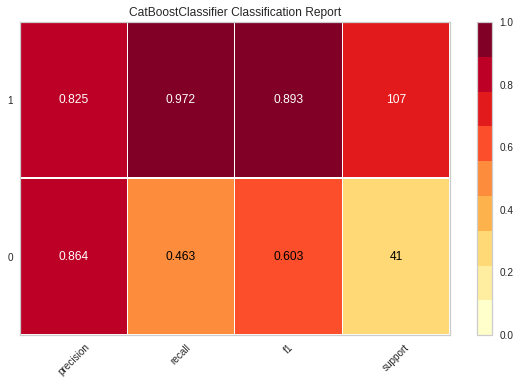

In [25]:
plot_model(tuned_model, plot = 'class_report')

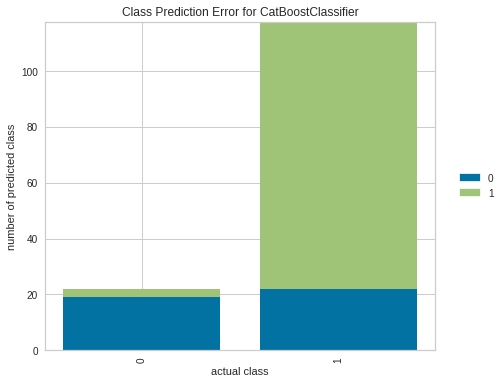

In [26]:
plot_model(tuned_model, plot='error')

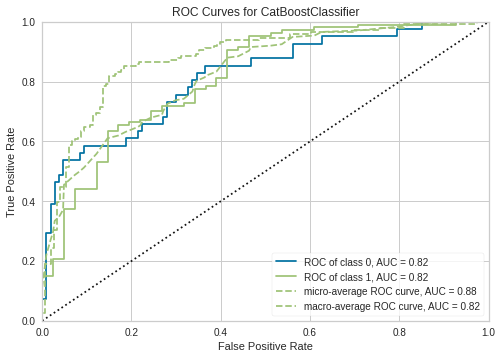

In [27]:
#plot a model
plot_model(tuned_model, plot='auc')

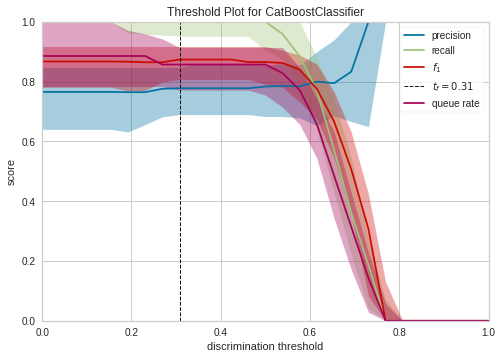

In [28]:
plot_model(tuned_model, plot='threshold')

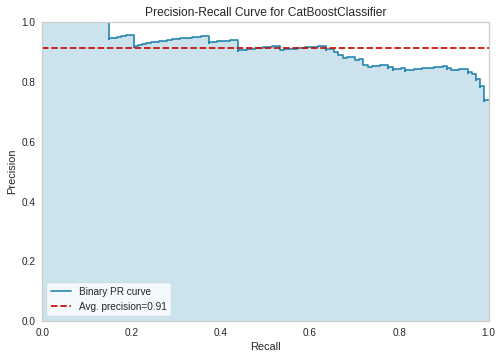

In [29]:
plot_model(tuned_model, plot = 'pr')

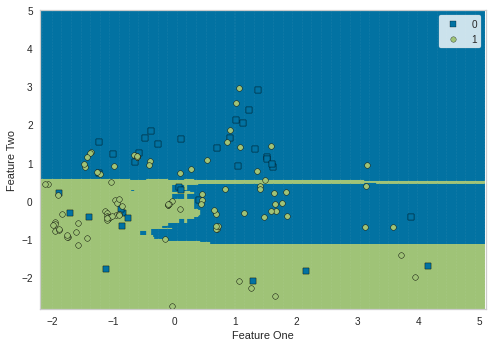

In [30]:
plot_model(tuned_model, plot='boundary')

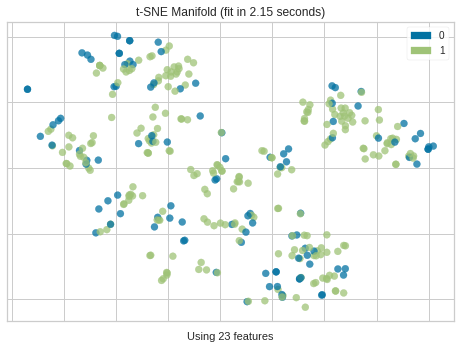

In [31]:
plot_model(tuned_model, plot='manifold')

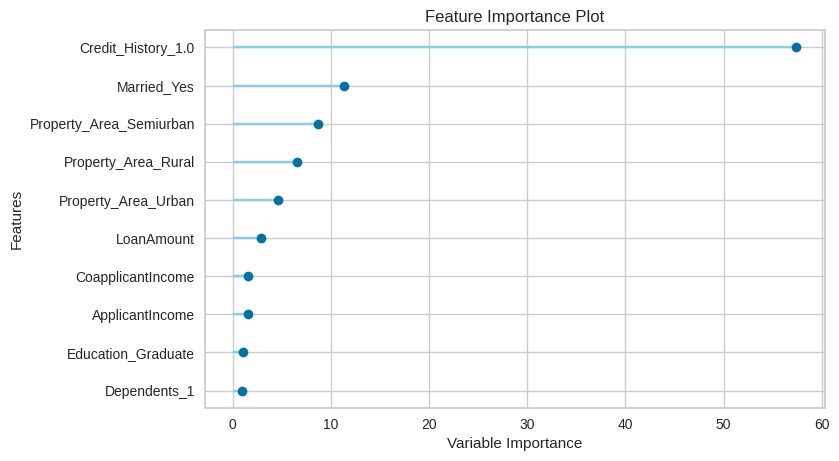

In [32]:

plot_model(tuned_model, plot='feature')

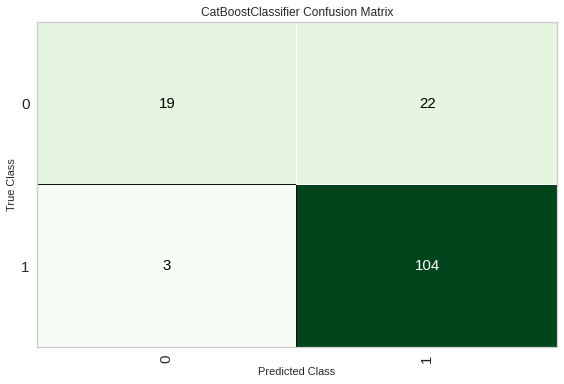

In [33]:
plot_model(tuned_model, plot = 'confusion_matrix')

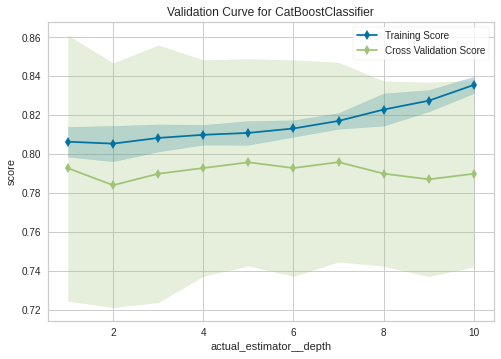

In [34]:
plot_model(tuned_model, plot='vc')

In [35]:
predict_model(tuned_model)

Model  Accuracy    AUC  Recall   Prec.      F1  Kappa     MCC
0  CatBoost Classifier    0.8311  0.816   0.972  0.8254  0.8927  0.508  0.5477

ApplicantIncome  CoapplicantIncome  LoanAmount  ...  Loan_Status  Label   Score
0          -0.548585           0.075210        74.0  ...            1      1  0.5768
1           0.065044           1.184896       187.0  ...            1      1  0.7575
2          -0.202069          -0.503953       124.0  ...            1      1  0.5963
3          -0.198082          -0.503953       115.0  ...            1      1  0.6649
4           0.064213          -0.503953       128.0  ...            1      1  0.6997
..               ...                ...         ...  ...          ...    ...     ...
143         0.501096           0.621946       187.0  ...            1      1  0.5266
144        -0.267851           0.096527       120.0  ...            1      1  0.6488
145        -0.052566          -0.503953       132.0  ...            1      1  0.5344
146        -0.258216          -0.003753       135.0  ...            1      1  0.5463
147        -0.301738          -0.178793       135.0  ...            1      1  0.6832

[148 rows x 27 columns]

##Interpret Model Predictions
<p>
If you are viewing this notebook on github, the next set of plots will not render as they require Javascript. SHAP interpretation

In [36]:
shap_models = ['xgboost', 'rf', 'catboost', 'et', 'lightgbm', 'dt']
run_shap = True if MODEL in shap_models else False
print(f'Cannot run SHAP model interpretation for {MODEL}' if run_shap == False else 'Running SHAP model interpretation. Plots require Javascript and may not render on github')

Running SHAP model interpretation. Plots require Javascript and may not render on github


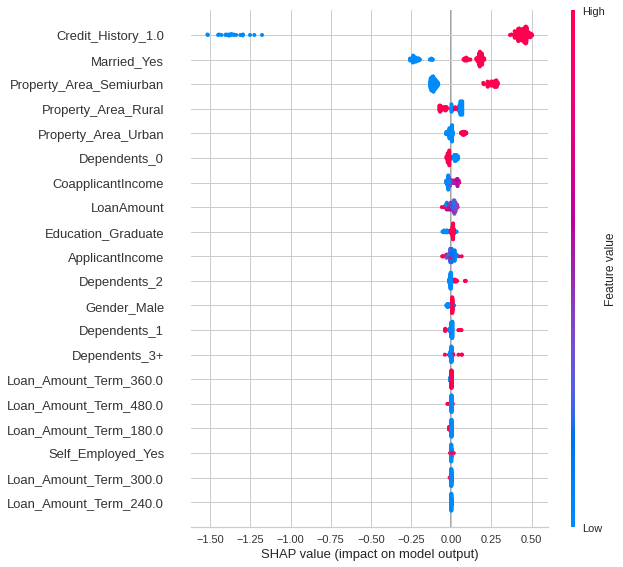

In [37]:
if run_shap:
  interpret_model(tuned_model)

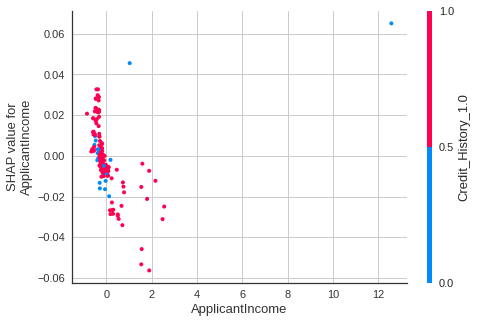

In [38]:
if run_shap:
  interpret_model(tuned_model, plot='correlation')

In [39]:
interpret_model(tuned_model, plot='reason', observation = 77)

In [40]:
interpret_model(tuned_model, plot='reason')

In [41]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Finalize the Model

In [42]:
final_model = finalize_model(tuned_model)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


In [43]:
print(final_model)

In [44]:
FINAL_MODEL_NAME_WITH_TS = EXPERIMENT_NAME + '_' + MODEL + '_' + UTC_TIMESTAMP
FINAL_MODEL_NAME_WITHOUT_TS = EXPERIMENT_NAME + '_' + MODEL

* Not sure if there are issues with putting a timestamp or a file name length constraint for cloud environments. I recall that Azure Machine Learning had an experiment name string length limit. For now, I will save the model again with a simple file name without the timestamp.

In [45]:
save_model(final_model, FINAL_MODEL_NAME_WITHOUT_TS)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Loan_ID'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Loan_Status', time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight=None,
                                                              c...
                 ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Loan_Status')),
                 ('fix_perfect', 

In [46]:
save_model(final_model, FINAL_MODEL_NAME_WITH_TS)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Loan_ID'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Loan_Status', time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight=None,
                                                              c...
                 ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Loan_Status')),
                 ('fix_perfect', 

In [47]:
!ls

catboost_info				  loan_train.csv
compare_model.csv			  logs.log
create_model.csv			  mlruns
dphi_ch54_1_catboost_20201231T223647.pkl  optimized_threshold_results.json
dphi_ch54_1_catboost.pkl		  sample_data
dtype_mapping.json			  tune_model.csv
loan_test.csv


# Load Model and Predict


In [48]:
loaded_model = load_model(FINAL_MODEL_NAME_WITHOUT_TS)

Transformation Pipeline and Model Successfully Loaded


In [49]:
loaded_model

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['Loan_ID'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='Loan_Status', time_features=[])),
                ('imputer',
                 Iterative_Imputer(add_indicator=False,
                                   classifier=LGBMClassifier(boosting_type='gbdt',
                                                             class_weight=None,
                                                             c...
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='Loan_Status')),
                ('fix_perfect', Remove_100(target

In [50]:
single_example = test_data.iloc[[1],:]

In [51]:
single_example.head()

Loan_ID Gender Married  ... Loan_Amount_Term Credit_History Property_Area
1  LP001488   Male     Yes  ...            360.0            1.0     Semiurban

[1 rows x 12 columns]

In [52]:
single_example.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1 to 1
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            1 non-null      object 
 1   Gender             1 non-null      object 
 2   Married            1 non-null      object 
 3   Dependents         1 non-null      object 
 4   Education          1 non-null      object 
 5   Self_Employed      1 non-null      object 
 6   ApplicantIncome    1 non-null      int64  
 7   CoapplicantIncome  1 non-null      float64
 8   LoanAmount         1 non-null      float64
 9   Loan_Amount_Term   1 non-null      float64
 10  Credit_History     1 non-null      float64
 11  Property_Area      1 non-null      object 
dtypes: float64(4), int64(1), object(7)
memory usage: 104.0+ bytes


In [53]:
prediction = predict_model(loaded_model, data= single_example)

In [54]:
prediction

Loan_ID Gender Married  ... Property_Area Label   Score
1  LP001488   Male     Yes  ...     Semiurban     1  0.7478

[1 rows x 14 columns]

In [55]:
batch_prediction = predict_model(loaded_model, data=test_data)

In [56]:
batch_prediction

Loan_ID  Gender Married  ... Property_Area Label   Score
0    LP001116    Male      No  ...     Semiurban     1  0.7203
1    LP001488    Male     Yes  ...     Semiurban     1  0.7478
2    LP002138    Male     Yes  ...         Rural     1  0.6294
3    LP002284    Male      No  ...         Rural     1  0.5390
4    LP002328    Male     Yes  ...         Rural     0  0.8113
..        ...     ...     ...  ...           ...   ...     ...
118  LP002683    Male      No  ...     Semiurban     1  0.7456
119  LP002054    Male     Yes  ...         Rural     1  0.6022
120  LP002757  Female     Yes  ...     Semiurban     1  0.7246
121  LP002582  Female      No  ...     Semiurban     1  0.6405
122  LP001616    Male     Yes  ...     Semiurban     1  0.7542

[123 rows x 14 columns]

In [57]:
submission = batch_prediction[['Label']]
submission.rename(columns={'Label':'prediction'}, inplace=True)
submission.index = test_data.index
submission.to_csv('prediction_results.csv', index=False)

In [58]:
logs = get_logs(save=True)
logs.head()

run_id  ...                      tags.mlflow.log-model.history
0  5be5dbf7f62749f2bef2165b80e47a63  ...  [{"run_id": "5be5dbf7f62749f2bef2165b80e47a63"...
1  9c49ee2e6873423ca6e29794cc9058e3  ...  [{"run_id": "9c49ee2e6873423ca6e29794cc9058e3"...
2  9f3a310ae17d479db8791e8918d85018  ...  [{"run_id": "9f3a310ae17d479db8791e8918d85018"...
3  d1deed632468494e91d06a4d86017586  ...  [{"run_id": "d1deed632468494e91d06a4d86017586"...
4  1d05fa89a3f146bd9f5b49b4cfddfebc  ...  [{"run_id": "1d05fa89a3f146bd9f5b49b4cfddfebc"...

[5 rows x 205 columns]

# Capture Schema Information
### Notes for Austin
* In my experience, it is super important to capture information about the training data schema and test data schema (without data leakage, of course!). When we start to build Flask or Streamlit front-ends we need to specifically code the requests so that it can be transformed into the exact schema that the model was trained on. Often, the front-end is developed by a different team. Saving the column names and dtypes into the experiment artifacts helps provide downstream development activities as well as allows the DS team to compare and contrast models built over time. For example, a data source schema could change, new columns come in to play, others are deprecated or removed. In this instance, PyCaret will perform different pipeline steps leading to models that require a different signature. This can often happen as the project progresses throught the DTAP stages and we are connecting to different data sources (DEV, TEST, PROD databases as an example).
* In this dataset, probably due to the way I loaded the CSV files, I see Credit_History come in as 0.0 or 1.0. Didn't think that much about it, PyCaret seemed happy and landed up creating dummy/indicator variables Credit_History_0.0 and Credit_History_1.0 **note: that, and the fact that there are 43 missing values in the training_data should have been my clue!!!**.  (It has to do with how pandas has chosen to deal with missing values, see [na type promotions](https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#na-type-promotions))
. When I tested the model on my local machine with a Streamlit front-end, I chose to represent Credit_History as a 1|0 dropdown. Strangely, all my predictions were returning the 0 case i.e. Loan was Declined. I even tried specific test cases and the model was just stingy with approving loans even with a million dollar salary! So here is a case where the model PyCaret is perfectly happy accepting the inputs, or remains silent about anything going in the pipeline to accept Credit_History $\in \{1,0\}$ when it was trained with Credit_History $\in \{1.0, 0.0\}$. During debug, I changed the Streamlit dropdown to take $\{1.0, 0.0\}$ and now the model is significantly less "Scroogy". The fix should happen when the CSV files are loaded during training. Checking the dtypes of the dataframe being sent to the model in Streamlit against the dtypes used during training would have caught this defect earlier.
### Do your Research!
* I'm not sure if MLflow or PyCaret is already recording some of this information. Since the default PyCaret model output contains both the model and its associated pipeline, we may be able to query this on load.
* What are the best practices from MLOps?
* TODO: I should be examining the columns created by the PyCaret pipeline.
* TODO: Understand what is happening under the hood when a model receives a column containing info with a different dtype. I think it expects things to slot into Credit_History_0.0 and Credit_History_1.0 but lands up creating Credit_History_0 and Credit_History_1.
* TODO: **Of-course, the Streamlit needs to present choices to the user in Business Language!**


In [59]:
import json

def schema_to_json(df, filename_prefix):
  '''
  Adapted from
  Source: https://stackoverflow.com/questions/50422404/save-and-export-dtypes-information-of-a-python-pandas-dataframe
  '''
  columns_filename = filename_prefix + '_columns.json'
  df.head(0).to_json(columns_filename)

  tmp = df.dtypes.to_frame('dtypes').reset_index()
  df_dtypes = tmp.set_index('index')['dtypes'].astype(str).to_dict()
  dtypes_filename = filename_prefix + '_dtypes.json'
  with open(dtypes_filename, 'w') as f:
    json.dump(df_dtypes, f)

In [60]:
schema_to_json(training_data, 'training_data')
schema_to_json(test_data, 'test_data')

# Capture Package Versions
### Notes for Austin
* Similarly, it is imperative that we can identify the exact versions of packages that we used in the Notebook, so that we can reproduce the environment on our local machines as well as for cloud deployments.

In [61]:
'''
Adapted from
Source: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
'''
package_versions = {m.__name__ : m.__version__ for m in globals().values() if getattr(m, '__version__', None)}
with open('package_versions.json','w') as f:
  json.dump(package_versions, f)

# Bundle Outputs and Download

In [62]:
# Google Colab places a folder of sample data in sample_data. We don't need that.
!rm -rf sample_data ||:

In [63]:
ZIP_ARCHIVE_NAME = FINAL_MODEL_NAME_WITH_TS + '.zip'

In [64]:
!zip -qr ./$ZIP_ARCHIVE_NAME ./

In [65]:
if DOWNLOAD_ZIPFILE:
  files.download(ZIP_ARCHIVE_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>